<a href="https://colab.research.google.com/github/Deepak-Mewada/NMA-CN/blob/main/Copy_of_Copy_of_load_stringer_orientations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Stringer orientations data

includes some visualizations

In [ ]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
#@title Data loading
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.


In [ ]:
print(dat['sresp'].shape)
print(len(dat['stat']))

(23589, 4598)
23589


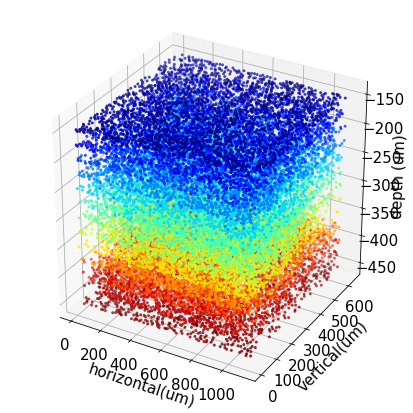

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1],z[::-1], 'o', s = 4, c = cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel = 'vertical(um)', zlabel='depth (um)');

In [ ]:
print(np.min(x),np.max(x))
print(np.min(y),np.max(y))
print(np.min(z),np.max(z))


6.0 1126.0
6.65 638.4000000000001
-450.0 -150.0


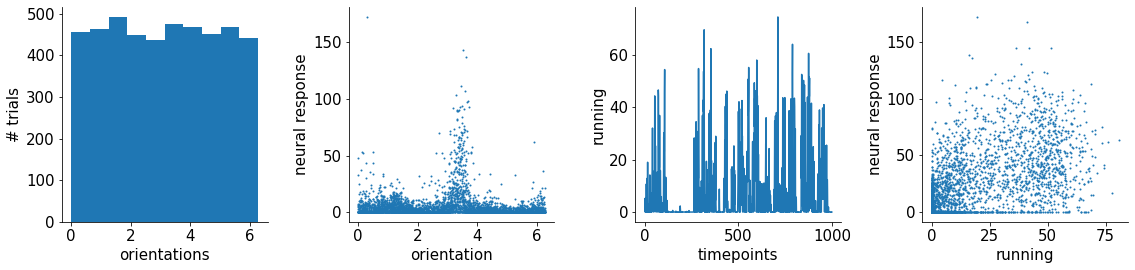

In [ ]:
#@title Basic data properties using plot, hist and scatter
ax = plt.subplot(1,5,1)
plt.hist(dat['istim'])
ax.set(xlabel='orientations', ylabel = '# trials')

ax = plt.subplot(1,5,2)
plt.scatter(dat['istim'], dat['sresp'][1000], s= 1)
ax.set(xlabel = 'orientation', ylabel = 'neural response')

ax = plt.subplot(1,5,3)
plt.plot(dat['run'][:1000])
ax.set(xlabel = 'timepoints', ylabel = 'running')

ax = plt.subplot(1,5,4)
plt.scatter(dat['run'], dat['sresp'][20998], s= 1)
ax.set(xlabel = 'running', ylabel = 'neural response')

plt.show()

In [ ]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 
Z = zscore(dat['sresp'], axis=1)
X = PCA(n_components = 200).fit_transform(Z.T)

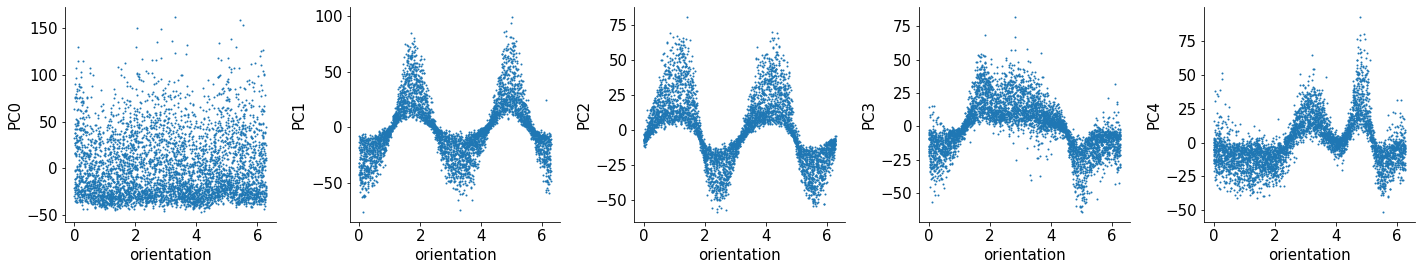

In [ ]:
#@title plot PCs as function of stimulus orientation
for j in range(5):
  ax = plt.subplot(1,5,j+1)
  plt.scatter(dat['istim'], X[:,j], s = 1)
  ax.set(xlabel='orientation', ylabel = 'PC%d'%j)
plt.show()

In [ ]:
#@title run a manifold embedding algorithm (UMAP) in two or three dimensions. 
!pip install umap-learn
from umap import UMAP
ncomp = 3 # try 2, then try 3
xinit = 3 * zscore(X[:,:ncomp], axis=0)
embed = UMAP(n_components=ncomp, init =  xinit, n_neighbors = 25, 
             metric = 'correlation', transform_seed = 42).fit_transform(X)

     |████████████████████████████████| 81kB 2.6MB/s 
     |████████████████████████████████| 1.1MB 17.8MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=a553071f1827c900cebb71d8d4c573f4ed855b5edee0aeefa283ddf76a9a58c0
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.4-cp37-none-any.whl size=52374 sha256=faa40d6af00b5d8c738a7dcaf0b526ec30059d95a5d5766d197ae493971ec322
  Stored in directory: /root/.cache/pip/wheels/42/4b/8c/f6f119c67cf6583bb192431fa8f7278cf95e5b943055077d94
Successfully built umap-learn pynndescent


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


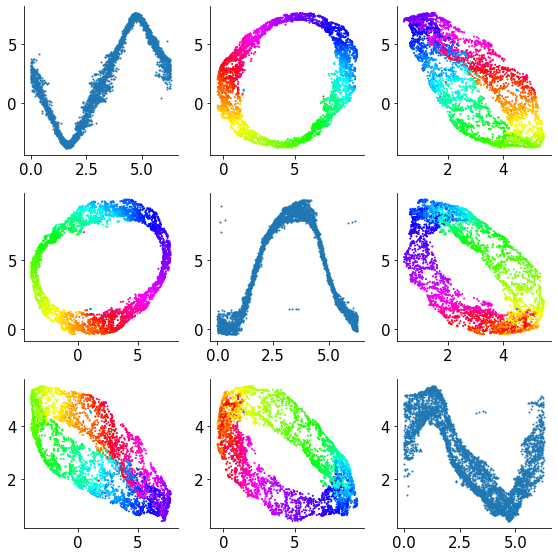

In [ ]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i==j:
      plt.scatter(dat['istim'], embed[:,i], s  = 1)
    else:
      plt.scatter(embed[:,j], embed[:,i], s  = 1, c= dat['istim'], cmap = 'hsv')
# Is that a Mobius strip? A good project would be to try to figure out why (I don't know). 

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import scipy.cluster.hierarchy as sch


In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
#model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

#model = model.fit(dat['sresp'])


In [ ]:
#labels = model.labels_

In [ ]:
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
X=dat['sresp']
plt.scatter(X[labels==0, 0], X[labels==0, 1], s=50, marker='o', color='red')
plt.scatter(X[labels==1, 0], X[labels==1, 1], s=50, marker='o', color='blue')
plt.scatter(X[labels==2, 0], X[labels==2, 1], s=50, marker='o', color='green')
plt.scatter(X[labels==3, 0], X[labels==3, 1], s=50, marker='o', color='purple')
plt.scatter(X[labels==4, 0], X[labels==4, 1], s=50, marker='o', color='orange')
plt.show()

# New Section

In [ ]:
def calculate_orientation_selectivity( neuron_response, orientations ):
	#Arguments:
  #neuron_response: ndarray (1 x Number of stimuli) - Neuron response to each stimulus.
  #orientations: ndarray (1 x Number of stimuli) - orientation of grating in each stimuli (in radians).
	#Returns:
  #orientation_selectivity: float - the preferred orientation (in radians) this neuron.
	#Description:
  #This function takes an array of responses for a single neuron, and an array of orientations which those responses correspond to. 
  #It then calculates which orientation generates the largest response for this neuron, and returns that orientation as a scalar value.

  max_activity_index=np.argmax(neuron_response)
  orientation_selectivity=orientations[max_activity_index]

  return orientation_selectivity

def calculate_all_orientation_selectivities( neuron_responses, orientations ):
	#Arguments:
  #neuron_responses: ndarray (no. of neurons x Number of stimuli) - Neuron responses to each stimulus.
  #orientations: ndarray (1 x Number of stimuli) - orientation of grating in each stimuli (in radians).
	#Returns:
  #orientation_selectivities: array (1 x Number of neurons) - the preferred orientations (in radians) for each neuron.
	#Description:
  #This function just applies the previous function (calculate_orientation_selectivity) over an array of multiple neurons, 
  #returning the feature selectivity for each neuron.
  orientation_selectivities=np.array([0.00] * len(neuron_responses))

  for i in range(len(neuron_responses)):
      orientation_selectivities[i]=calculate_orientation_selectivity(dat['sresp'][i],dat['istim'])

  return orientation_selectivities



In [ ]:
orientation_selectivities=calculate_all_orientation_selectivities(dat['sresp'],dat['istim'])

In [ ]:

def calculate_orientation_diff(orientation1,orientation2):
    diff=np.absolute(orientation1-orientation2)
    if(diff>np.pi): diff=diff-np.pi
    return diff
    
def quantify_pinwheel( neuron_positions, orientation_selectivities):
	#Arguments:
  #neuron_positions: ndarray (no. of neurons x 3) - The xyz position of each neuron
  #orientation_selectivites: ndarray (1 x Number of neurons) - orientation selectivity of each neuron (in radians).
	#Returns:
  #euclidean _distances: ndarray (Number of neurons X Number of neurons) of pairwise distances between neurons.
  #orientation_similarity: ndarray (Number of neurons X Number of neurons) of cosine similarity between pairwise combinations of neurons.
  #Description:
  #This function should compare the orientation selectivities for all neurons using cosine similarity and calculate the euclidean distance between them, returning each as a vector.

  x,y,z=neuron_positions
  n=len(neuron_positions[0])
  euclidean_distances=[]
  orientation_similarity=[]
  
  for i in range(n):
    for j in range(n) :
      euclidean_distances[i].append(np.sqrt((x[i]-x[j])**2+ (y[i]-y[j])**2 +(z[i]-z[j])**2))
      orientation_similarity[i].append(calculate_orientation_diff(orientation_selectivities[i],orientation_selectivities[j]))
            
  return euclidean_distances,orientation_similarity


In [ ]:
euclidean_distances,orientation_similarity=quantify_pinwheel(dat['xyz'][:,0:10],orientation_selectivities)
print(euclidean_distances)
print(orientation_similarity)

IndexError: ignored

No handles with labels found to put in legend.


[0.0, 638.8204833910697, 203.94139574887686, 701.8287273259766, 577.4984710802272, 638.8204833910697, 0.0, 742.4460094175198, 1149.4475292504655, 122.4605736553606, 203.94139574887686, 742.4460094175198, 0.0, 498.99563164420584, 654.0486835091101, 701.8287273259766, 1149.4475292504655, 498.99563164420584, 0.0, 1037.3117379071732, 577.4984710802272, 122.4605736553606, 654.0486835091101, 1037.3117379071732, 0.0, 0.0]
[0.0, 2.186650544780574, 0.23876615720016936, 0.6138176210970139, 1.1322395874847158, 2.186650544780574, 0.0, 1.1937082660093883, 1.5728329236835603, 1.0544109572958584, 0.23876615720016936, 1.1937082660093883, 0.0, 2.7665411896929486, 2.2481192233052467, 0.6138176210970139, 1.5728329236835603, 2.7665411896929486, 0.0, 0.5184219663877019, 1.1322395874847158, 1.0544109572958584, 2.2481192233052467, 0.5184219663877019, 0.0, 0.0]


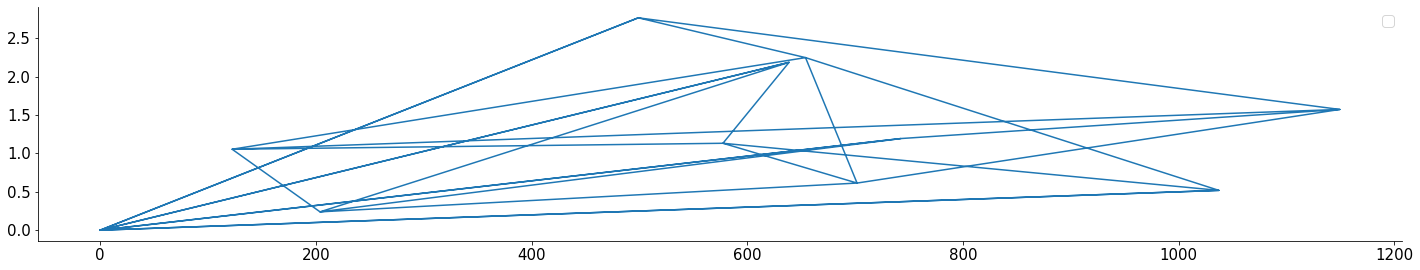

In [ ]:

euclidean_distances,orientation_similarity=quantify_pinwheel(dat['xyz'][:,0:5],orientation_selectivities)
print(euclidean_distances)
#euclidean_distances=euclidean_distances/(np.linalg.norm(euclidean_distances) + 1e-16)
#print(euclidean_distances)
print(orientation_similarity)
#orientation_similarity=orientation_similarity/(np.linalg.norm(orientation_similarity) + 1e-16)
#print(orientation_similarity)
plt.plot(euclidean_distances,orientation_similarity)


#plt.plot(x,orientation_similarity,label = "orientation_similarity")
# # naming the x axis
# plt.xlabel('neuron')
# # naming the y axis
# plt.ylabel('Avg orientation')
# # giving a title to my graph
# plt.title('Orientation Selectivity Average for a neuronal cluster vs neuron')
# # show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

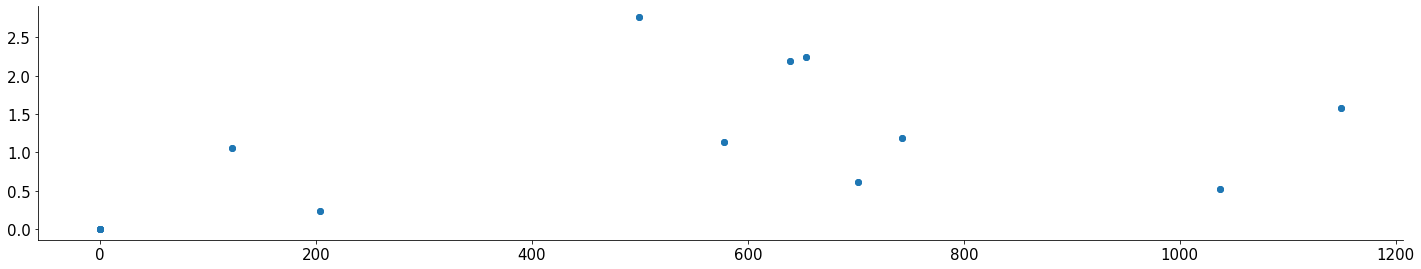

In [ ]:
plt.scatter(euclidean_distances,orientation_similarity)

<BarContainer object of 26 artists>

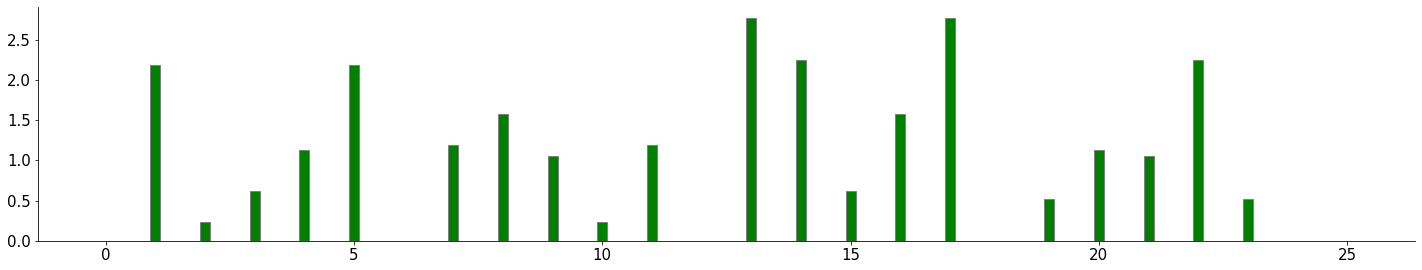

In [ ]:
# Make the plot
x=np.array(range(0,len(euclidean_distances)))
plt.bar(x,euclidean_distances, color ='r', width = 0.2,
        edgecolor ='grey', label ='euclidean_distances')
plt.bar(x, orientation_similarity, color ='g', width = 0.2,
        edgecolor ='grey', label ='orientation_similarity')